#### This analysis assumes a white noise spectrum

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
import pandas as pd

#### Plotting paramerters

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 23,
          'axes.titlesize': 23,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize':6,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [116]:
def cmpt_bunch_length_correction_factor(sigma_phi, phase_noise = True):
    '''
    This function computes the correction factor, C, due to the bunch length, sigma_phi, assuming a 2D gaussian longitudinal distribution.
    - phase_noise = True (False): computes C for phase (amplitude) noise case
    - sigma_phi: in radians at the CC frequency
    
    - Io, I2l: Modified Bessel functions of the first kind. 
    - I2l: It converges to zero for larger orders. Therefore, a summation up to a large integer, here 10000 is used,  gives us trustworthy resutls.
    
    Note: Possibility to compute the factors for a pillbox distribution which is the other extreme (email from Themis). 
    '''

    if phase_noise:
        Io = iv(0, sigma_phi**2) # The first argument is the order
        I2l_sum = 0
        for order in range(2, 10000, 2):
            I2l_sum = I2l_sum + iv(order, sigma_phi**2)
         
        C = np.exp(-sigma_phi**2)*(Io+2*I2l_sum)
        
    else:
        I2ll_sum = 0
        for order in range(0, 10000, 2):
            I2ll_sum = I2ll_sum + iv(order+1, sigma_phi**2)
        
        C = np.exp(-sigma_phi**2)*I2ll_sum
        
    return C

In [4]:
def emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaPhi, PSD_phi):
    ey_rate = betay*(Vcc*frev/(2*Eb))**2*CDeltaPhi*PSD_phi
    return 2*ey_rate # the factor of 2 corresponds to the number of betatron sidebands we "see"

In [5]:
def emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A):
    ey_rate = betay*(Vcc*frev/(2*Eb))**2*CDeltaA*PSD_A
    return 4*ey_rate # the factor of 4 corresponds to the number of betatron and synchrobetatron sidebands we "see"

In [117]:
def bunch_length_m_to_rad(L, clight, f_RF):
    phi = L*(2*np.pi*f_RF)/clight
    return phi

#### 1) Define the type of noise and other simulation parameters

In [8]:
phase_noise = True # False for amplitude noise
turns = 1e5
f_rev = 43375.86 # [Hz] The revolution frequency of the machine 
clight = 299792458

#### 2) Compute the theoretical predicted rate in m/s

In [118]:
# Machine parameters
betay = 76 # m
Vcc = 1e6# V
frev = 43.45e3 # Hz
Eb = 270e9 # eV
A = 3e-9 # rms kick in the simulation
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
beta_0 = 0.999999
gamma_0 = 287.7
sigma_z = 0.155
f_CC = 400.789e6 # Hz
CDeltaA = 0.14
CDeltaPhi = 0.51
# Compute the PSD in rad^2/Hz
PSD = (A * scale_factor)**2/frev # rad^2/Hz
print(PSD)

1.5100115074798618e-11


In [119]:
# Compute the correction factor due to the bunch length
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
C = cmpt_bunch_length_correction_factor(sigma_phi, phase_noise)
print(C)

0.5168486015622045


In [120]:
if phase_noise:
    dey_theoretical = emit_growth_phase_noise(betay, Vcc, frev, Eb, C, PSD)*beta_0*gamma_0 # m/s
else:
    dey_theoretical = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, C , PSD)*beta_0*gamma_0 # m/s

#### 3) Load the data for the trasnverse emittance growth from /afs/ and perform the analysis

In [121]:
n_runs = 3 # number of runs that the simulation was repeated
if phase_noise:
    type_of_noise = 'PN'
else:
    type_of_noise = 'AN'

path_to_data = '/afs/cern.ch/work/n/natriant/private/sixtracklib_example_crabcavity/tbt_from_GPUs/PSD_dependence/{}/'.format(type_of_noise)

In [122]:
ex_dict = {} # type: dictionary
ey_dict = {}

for run in range(n_runs):        
    temp_name = 'A{}_run{}'.format(str(A), run) # the suffix of the name of the current study
    # A. load the turn by turn data in a dictionary
    temp_dict = pickle.load( open( path_to_data+'tbt_A_{}_run{}.pkl'.format(str(A), run), "rb" ) )
    # B. Create a different list for each run and save the emittance values
    ex_dict[temp_name] = temp_dict['neps_x'] # PΝ
    ey_dict[temp_name] = temp_dict['neps_y']

#### 4) Convert turns to time

In [123]:
turns_list = np.arange(0,turns)
time = turns_list/f_rev # [s], type: list

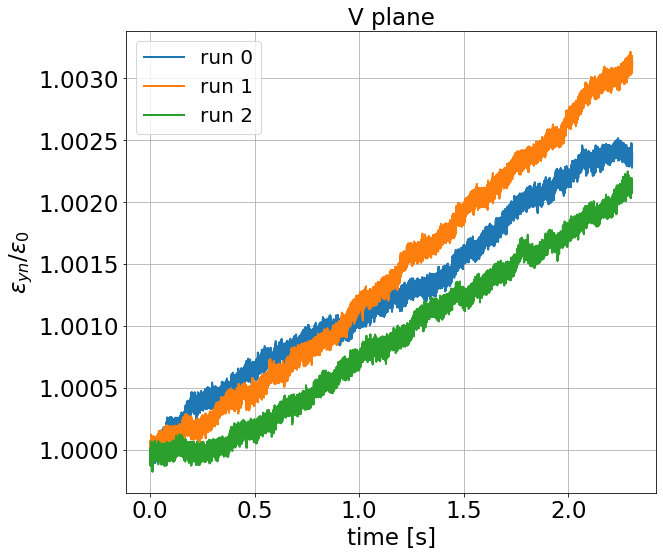

In [124]:
for run in range(n_runs):  
    temp_name = 'A{}_run{}'.format(str(A), run) # the suffix of the name of the current study
    plt.plot(time, ey_dict[temp_name]/ey_dict[temp_name][0], label='run {}'.format(run))
    
plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_{yn} / \epsilon_0$')
plt.title('V plane')
plt.legend(loc=0)
plt.grid()

#### 5) Here the mean and the standard deviation of the emittance values are computed over all runs. 

In [125]:
ex_mean = []
ex_std = []


ey_mean = []
ey_std = []


for turn in range(int(turns)):
    ey_temp = []
    ex_temp = []

    # keep all the emittance values for all the runs
    for run in range(n_runs):
        temp_name = 'A{}_run{}'.format(str(A), run)
        ey_temp.append(ey_dict[temp_name][turn])
        ex_temp.append(ex_dict[temp_name][turn])
    # calculate and append the mean of the emittance value for every turn
    ey_mean.append(np.mean(ey_temp))
    ex_mean.append(np.mean(ex_temp))
    # calculate and append the standard deviation of the emittance value for every turn
    ey_std.append(np.std(ey_temp))    
    ex_std.append(np.std(ex_temp))    

#### 6a) Plot the evolution of the H, horizontal, emittance

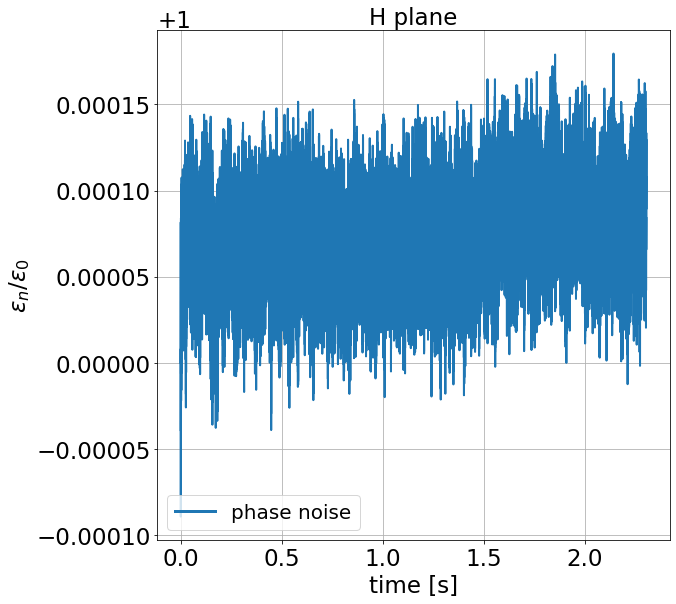

In [126]:
plt.plot(time, ex_mean/ex_mean[0], c='C0')
plt.plot(1,1,c='C0',  label = 'phase noise', linewidth = 3)      
plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_n / \epsilon_0$')
plt.title('H plane')
plt.legend(loc=3)
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('H_270GeV_SPS_noCC_PN1e-8_VRF2_37MV_1e5Nb_1e5turns_mean10runs.png')

#### 6b) Plot the evolution of the V, vertical, emittance

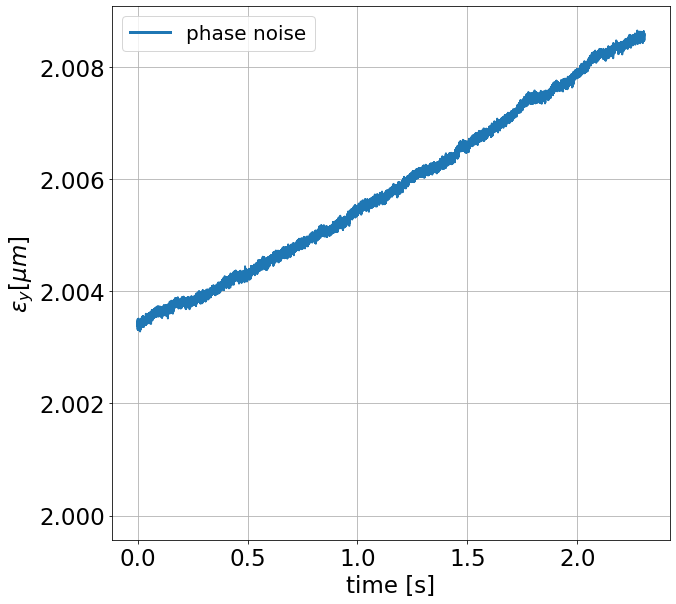

In [127]:
plt.plot(time, np.array(ey_mean)*1e6, c='C0')    
plt.plot(2,2,c='C0',  label = 'phase noise', linewidth = 3)    
plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emittance_growth_270GeV_SPS_noCC_PN1e-8_VRF2_37MV_1e5Nb_1e5turns_mean10runs.png')

#### 7) Plot evolution of the standard deviation $\sigma$ of the emittance values (for the vertical plane)

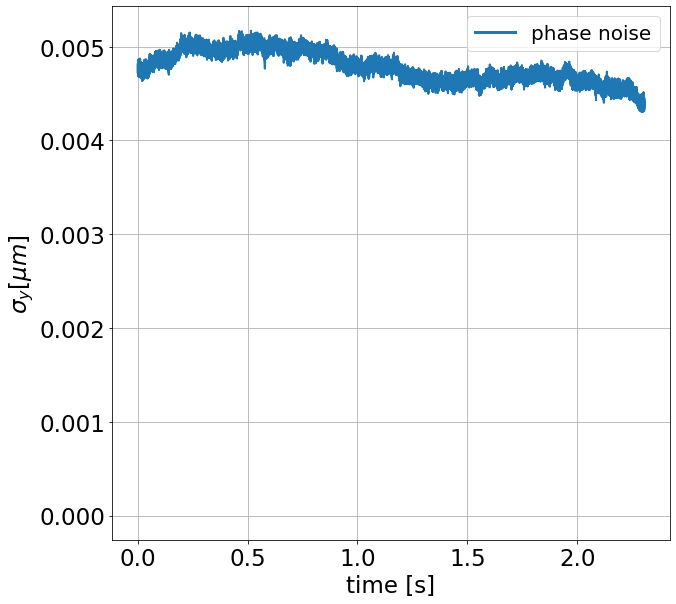

In [128]:
plt.plot(time, np.array(ey_std)*1e6, c='C0')   
plt.plot(0,0,c='C0',  label = 'phase noise', linewidth = 3)   
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma_y [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_std_270GeV_SPS_noCC_PN1e-8_VRF2_37MV_1e5Nb_1e5turns_mean10runs.png')

#### 8) Compute the emittance growth rate via a linear fit
- Polynomial fit. The degree of the fitting polynomial is 1. 
- V plane only

In [129]:
# linear fit
[m_pn, b_pn], cov_pn = np.polyfit(time, ey_mean, 1, cov=True)
# compute the error of the gradient of the fit slope
err_pn = np.sqrt(np.diag(cov_pn))

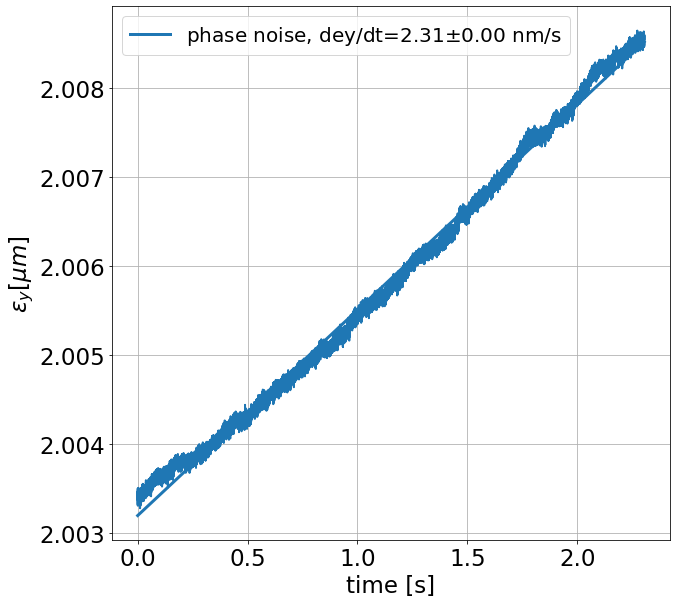

In [130]:
plt.plot(time, np.array(ey_mean)*1e6, c='C0')
plt.plot(time, (m_pn*time+b_pn)*1e6, c = 'C0', label='phase noise, dey/dt={0:.2f}'.format(m_pn*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_pn[0]*1e9), linewidth = 3)

plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emittance_growth_rate_270GeV_SPS_noCC_{}1e-8_VRF2_37MV_1e5Nb_1e5turns_mean{}runs.png'.format(type_of_noise, n_runs))

#### 9) Plot fill between

In [131]:
if type_of_noise == 'PN':
    my_color = 'C0'
    fill_bewtween_color = 'lightblue'
else:
    my_color = 'C1'
    fill_bewtween_color = 'moccasin'

#### A) y axis emittance values

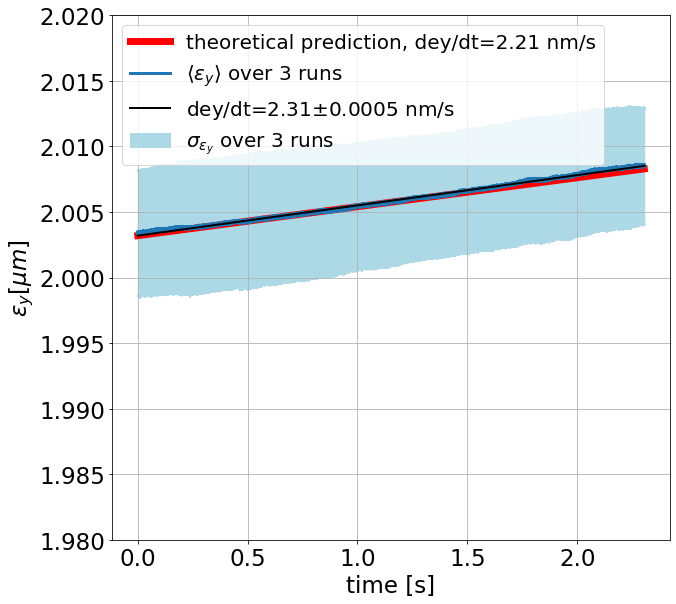

In [132]:
# std over all runs
plt.fill_between(time, np.array(ey_mean)*1e6 - np.array(ey_std)*1e6, np.array(ey_mean)*1e6 + np.array(ey_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))

# expected slope from analytical calculations
plt.plot(time, (dey_theoretical*time+b_pn)*1e6, c='r', linewidth=7, label='theoretical prediction, dey/dt={0:.2f} nm/s'.format(dey_theoretical*1e9))

# emittance values obtained from the simulation averaged over turns
plt.plot(time, np.array(ey_mean)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_y \rangle $'+' over {} runs'.format(n_runs))

# linear fit on the emittance values obtained from the simulation averaged over turns
plt.plot(time, (m_pn*time+b_pn)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m_pn*1e9)+'$\pm$'+'{0:.4f} nm/s'.format(err_pn[0]*1e9), linewidth = 2)



plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.ylim(1.98, 2.02)
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emittance_growth_rate_270GeV_SPS_noCC_{}1e-8_VRF2_37MV_1e5Nb_1e5turns_mean{}run_fill_between_v2.png'.format(type_of_noise, n_runs))

#### B) y axis: emittance values after substracting the initial emittance

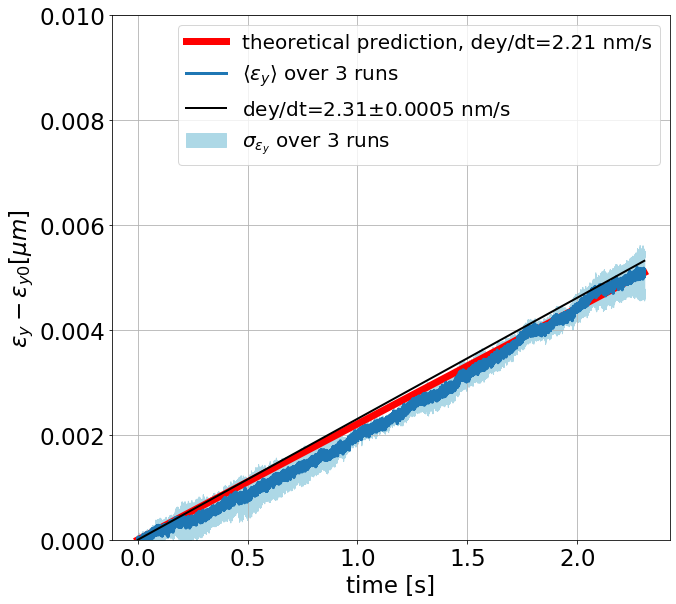

In [133]:
initial_std = ey_std[0]
initial_mean_emittance = ey_mean[0]
# std over all runs
plt.fill_between(time, np.array(ey_mean-initial_mean_emittance )*1e6 - np.array(ey_std-initial_std)*1e6, np.array(ey_mean-initial_mean_emittance)*1e6 + np.array(ey_std-initial_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))

# expected slope from analytical calculations
plt.plot(time, (dey_theoretical*time)*1e6, c='r', linewidth=7, label='theoretical prediction, dey/dt={0:.2f} nm/s'.format(dey_theoretical*1e9))

# emittance values obtained from the simulation averaged over turns
plt.plot(time, np.array(ey_mean-initial_mean_emittance)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_y \rangle $'+' over {} runs'.format(n_runs))

# linear fit on the emittance values obtained from the simulation averaged over turns
plt.plot(time, (m_pn*time)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m_pn*1e9)+'$\pm$'+'{0:.4f} nm/s'.format(err_pn[0]*1e9), linewidth = 2)



plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y - \epsilon_{y0} [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.ylim(0, 0.01)
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emit_growth_rate_substract_initial_emittance_270GeV_SPS_noCC_{}1e-8_VRF2_37MV_1e5Nb_1e5turns_mean{}run_fill_between.png'.format(type_of_noise, n_runs))